# Convolutional Autoencoder using TensorFlow library

In [82]:
# Import required packages

import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

In [83]:
# Load the data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [84]:
batch_size = 64
latent_space = 128
learning_rate = 0.1

n_epochs = 100

In [85]:
# Let's define weights and bias values for the model

ae_weights = {
    "encoder_conv": tf.Variable(
        tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
    "encoder_bias": tf.Variable(
        tf.truncated_normal([4], stddev=0.1)),
    "decoder_deconv": tf.Variable(
        tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
    "decoder_bias": tf.Variable(
        tf.truncated_normal([1], stddev=0.1))
}

In [118]:
input_shape = [batch_size, 28, 28, 1]

In [119]:
ae_input = tf.placeholder(tf.float32, input_shape)

hidden = tf.nn.sigmoid(tf.nn.conv2d(ae_input, 
                                    ae_weights["encoder_conv"], 
                                    strides=[1, 2, 2, 1], 
                                    padding="SAME") + ae_weights["encoder_bias"])

visible_logits = tf.nn.conv2d_transpose(hidden,
                                       ae_weights["decoder_deconv"],
                                       input_shape,
                                       strides=[1, 2, 2, 1],
                                       padding="SAME") + ae_weights["decoder_bias"]

visible = tf.nn.sigmoid(visible_logits)

In [120]:
optimizer = tf.train.AdagradOptimizer(learning_rate)

cost = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=visible_logits, labels=ae_input))

conv_op = optimizer.minimize(cost)

In [121]:
n_batches = mnist.train.num_examples // batch_size

In [122]:
original_images, _ = mnist.test.next_batch(batch_size)

In [123]:
def train(op, cost, visible, n_epochs = 100):
    training_losses = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for epoch in range(1, n_epochs + 1):
        
            print(f"Epoch {epoch}/{n_epochs}")
        
            current_training_loss = 0
            step = 0
        
            for batch in range(n_batches):
                x_batch, _ = mnist.train.next_batch(batch_size)

                images = x_batch.reshape([-1, 28, 28, 1])
            
                step += 1
                
                _, loss = sess.run([op, cost], feed_dict={ae_input: images})
                current_training_loss += loss
            
                sys.stdout.write(f"\r\tDone: {step / n_batches * 100:0.1f}%, Loss: {(current_training_loss / step):2.4f}")
        
            training_losses.append(current_training_loss / n_batches)
        
            print()

        result = sess.run(visible, feed_dict={ae_input: original_images.reshape([-1, 28, 28, 1])})
        
    return result, training_losses

In [124]:
result_images, losses = train(conv_op, cost, visible, n_epochs=10)

Epoch 1/10
	Done: 100.0%, Loss: 0.1972
Epoch 2/10
	Done: 100.0%, Loss: 0.1174
Epoch 3/10
	Done: 100.0%, Loss: 0.0993
Epoch 4/10
	Done: 100.0%, Loss: 0.0908
Epoch 5/10
	Done: 100.0%, Loss: 0.0866
Epoch 6/10
	Done: 100.0%, Loss: 0.0839
Epoch 7/10
	Done: 100.0%, Loss: 0.0821
Epoch 8/10
	Done: 100.0%, Loss: 0.0807
Epoch 9/10
	Done: 100.0%, Loss: 0.0796
Epoch 10/10
	Done: 100.0%, Loss: 0.0786


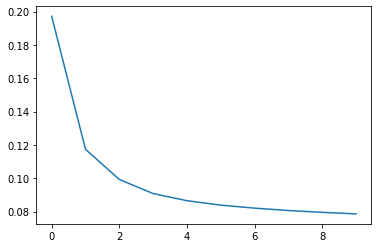

In [125]:
# Let's check how training loss looks
plt.plot(losses)

In [126]:
def plot_imgs(original_images, result_images):
    # Plot the first ten input images and ten reconstructed images
    # Input images on top, reconstructed on bottom
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

    for images, row in zip([original_images, result_images], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape(-1, 28), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)        

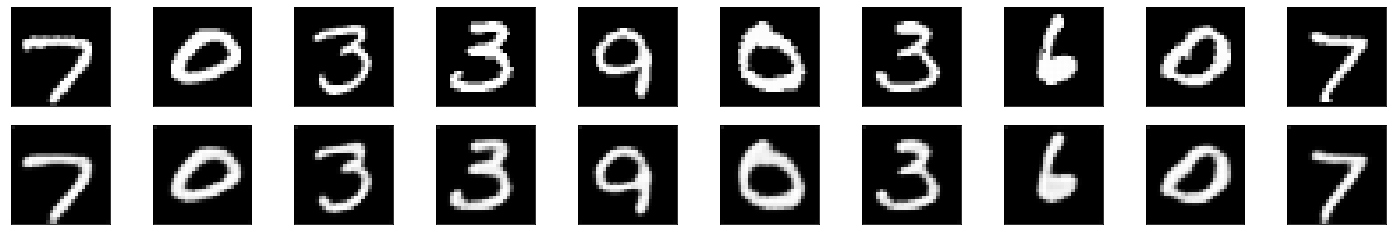

In [127]:
plot_imgs(original_images, result_images)

# Deeper autoencoder

Let's try to implement autoencoder which uses more hidden layers

In [103]:
deep_encoder_weights = {
    'encoder_input_conv': tf.Variable(
        tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
    'encoder_input_bias': tf.Variable(
        tf.truncated_normal([4], stddev=0.1)),
    'encoder_hidden_conv': tf.Variable(
        tf.truncated_normal([5, 5, 4, 8], stddev=0.1)),
    'encoder_hidden_bias': tf.Variable(
        tf.truncated_normal([8], stddev=0.1)),
    'decoder_hidden_deconv': tf.Variable(
        tf.truncated_normal([5, 5, 4, 8], stddev=0.1)),
    'decoder_hidden_bias': tf.Variable(
        tf.truncated_normal([4], stddev=0.1)),
    'decoder_output_deconv': tf.Variable(
        tf.truncated_normal([5, 5, 1, 4], stddev=0.1)),
    'deconv_output_bias': tf.Variable(
        tf.truncated_normal([1], stddev=0.1))
}

In [104]:
images = ae_input.reshape(input_shape)

encoder_input_out = tf.nn.leaky_relu(
    tf.nn.conv2d(images,
                 deep_encoder_weights['encoder_input_conv'],
                 strides=[1, 2, 2, 1],
                 padding='SAME') + deep_encoder_weights['encoder_input_bias'])
    
encoder_hidden_out = tf.nn.leaky_relu(
    tf.nn.conv2d(encoder_input_out,
                deep_encoder_weights['encoder_hidden_conv'],
                strides=[1, 2, 2, 1],
                padding='SAME') + deep_encoder_weights['encoder_hidden_bias'])

decoder_hidden_out = tf.nn.leaky_relu(
    tf.nn.conv2d_transpose(encoder_hidden_out,
                           deep_encoder_weights['decoder_hidden_deconv'],
                           [batch_size, 14, 14, 4], #Shape
                           strides=[1, 2, 2, 1],
                           padding='SAME') + deep_encoder_weights['decoder_hidden_bias'])

decoder_output = tf.nn.sigmoid(
    tf.nn.conv2d_transpose(decoder_hidden_out,
                          deep_encoder_weights['decoder_output_deconv'],
                          input_shape,
                          strides=[1, 2, 2, 1],
                          padding='SAME') + deep_encoder_weights['deconv_output_bias'])

In [105]:
optimizer_adam = tf.train.AdamOptimizer()

deep_cost = tf.reduce_mean(tf.squared_difference(decoder_output, deep_encoder_input))

deep_ae_op = optimizer_adam.minimize(deep_cost)

result_images, losses = train(deep_ae_op, deep_cost, decoder_output, n_epochs=10)

Epoch 1/10
(64, 28, 28, 1)
float32


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_20' with dtype float and shape [64,28,28,1]
	 [[node Placeholder_20 (defined at /home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'Placeholder_20':
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-b1019aaf1ab4>", line 1, in <module>
    deep_encoder_input = tf.placeholder(tf.float32, input_shape)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tensorflow_core/python/ops/array_ops.py", line 2619, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_array_ops.py", line 6669, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/sergey/anaconda3/envs/tensorflow115/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
